<div>
<img src="https://drive.google.com/uc?export=view&id=1vK33e_EqaHgBHcbRV_m38hx6IkG0blK_" width="350"/>
</div> 

#**Artificial Intelligence - MSc**
##ET5003 - MACHINE LEARNING APPLICATIONS 

###Instructor: Enrique Naredo
###ET5003_Etivity-2

In [1]:
#@title Current Date
Today = '2021-08-22' #@param {type:"date"}


In [2]:
#@markdown ---
#@markdown ### Enter your details here:
Student_ID = "20214537" #@param {type:"string"}
Student_full_name = "Tom Keane" #@param {type:"string"}
#@markdown ---

In [3]:
#@title Notebook information
Notebook_type = 'Example' #@param ["Example", "Lab", "Practice", "Etivity", "Assignment", "Exam"]
Version = 'Draft' #@param ["Draft", "Final"] {type:"raw"}
Submission = False #@param {type:"boolean"}

# INTRODUCTION

**Piecewise regression**, extract from [Wikipedia](https://en.wikipedia.org/wiki/Segmented_regression):

Segmented regression, also known as piecewise regression or broken-stick regression, is a method in regression analysis in which the independent variable is partitioned into intervals and a separate line segment is fit to each interval. 

* Segmented regression analysis can also be performed on 
multivariate data by partitioning the various independent variables. 
* Segmented regression is useful when the independent variables, clustered into different groups, exhibit different relationships between the variables in these regions. 

* The boundaries between the segments are breakpoints.

* Segmented linear regression is segmented regression whereby the relations in the intervals are obtained by linear regression. 

***The goal is to use advanced Machine Learning methods to predict House price.***

## Imports

In [4]:
# Suppressing Warnings:
import warnings
warnings.filterwarnings("ignore")

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import arviz as az
from sklearn.preprocessing import StandardScaler
import seaborn as sns

In [6]:
# to plot
import matplotlib.colors
from mpl_toolkits.mplot3d import Axes3D

# to generate classification, regression and clustering datasets
import sklearn.datasets as dt

# to create data frames
from pandas import DataFrame

# to generate data from an existing dataset
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV

In [7]:
# Define the seed so that results can be reproduced
seed = 11
rand_state = 11

# Define the color maps for plots
color_map = plt.cm.get_cmap('RdYlBu')
color_map_discrete = matplotlib.colors.LinearSegmentedColormap.from_list("", ["red","cyan","magenta","blue"])

# DATASET

Extract from this [paper](https://ieeexplore.ieee.org/document/9300074):

* House prices are a significant impression of the economy, and its value ranges are of great concerns for the clients and property dealers. 

* Housing price escalate every year that eventually reinforced the need of strategy or technique that could predict house prices in future. 

* There are certain factors that influence house prices including physical conditions, locations, number of bedrooms and others.


1. [Download the dataset](https://github.com/UL-ET5003/ET5003_SEM1_2021-2/tree/main/Week-3). 

2. Upload the dataset into your folder.



The challenge is to predict the final price of each house.

## Training & Test Data

In [8]:
def import_datasets(git_link = 'https://raw.githubusercontent.com/tomkeane07/AI-Projects-UL/main/semester3/MachineLearningApplications/PiecewiseRegression'):
  return {
      'house_test' : pd.read_csv(git_link+'/house_test.csv'),
      'house_train' : pd.read_csv(git_link+'/house_train.csv'),
      'true_price'  : pd.read_csv(git_link+'/true_price.csv')}

# try:
#   dbs
# except:
#   dbs = import_datasets()
dbs = import_datasets()


# split data into training and test
from sklearn.model_selection import train_test_split

# training: 70% (0.7), test: 30% (0.3) 
# you could try any other combination 
# but consider 50% of training as the low boundary
# X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.3)

### Train dataset

In [9]:
dftest = dbs['house_test' ]
dftrain =  dbs['house_train']
dfcost = dbs['true_price']

In [10]:
# show first data frame rows 
display(dftrain.head())

,ad_id,area,bathrooms,beds,ber_classification,county,description_block,environment,facility,features,latitude,longitude,no_of_units,price,property_category,property_type,surface
0,996887,Portmarnock,NaN,NaN,NaN,Dublin,A SELECTION OF 4 AND 5 BEDROOM FAMILY HOMES LO...,prod,NaN,None,53.418216,-6.149329,18.0,NaN,new_development_parent,NaN,NaN
1,999327,Lucan,NaN,NaN,NaN,Dublin,**Last 2 remaining houses for sale ***\n\nOn v...,prod,NaN,None,53.364917,-6.454935,3.0,NaN,new_development_parent,NaN,NaN
2,999559,Rathfarnham,NaN,NaN,NaN,Dublin,Final 4 &amp; 5 Bedroom Homes for Sale\n\nOn V...,prod,NaN,None,53.273447,-6.313821,3.0,NaN,new_development_parent,NaN,NaN
3,9102986,Balbriggan,NaN,NaN,NaN,Dublin,"Glenveagh Taylor Hill, Balbriggan\n\n*Ideal st...",prod,NaN,None,53.608167,-6.210914,30.0,NaN,new_development_parent,NaN,NaN
4,9106028,Foxrock,NaN,NaN,NaN,Dublin,*New phase launching this weekend Sat &amp; Su...,prod,NaN,None,53.262531,-6.181527,8.0,NaN,new_development_parent,NaN,NaN


In [11]:
display(dftest.head())

,ad_id,area,bathrooms,beds,ber_classification,county,description_block,environment,facility,features,latitude,longitude,no_of_units,property_category,property_type,surface
0,12373510,Skerries,2.0,4.0,G,Dublin,"It's all in the name ""Island View"";. Truly won...",prod,"Parking,Alarm,Oil Fired Central Heating",Breath-taking panoramic views radiate from thi...,53.566881,-6.101148,NaN,sale,bungalow,142.0
1,12422623,Lucan,2.0,3.0,C1,Dublin,REA McDonald - Lucan' s longest established es...,prod,NaN,Gas fired central heating.\nDouble glazed wind...,53.362992,-6.452909,NaN,sale,terraced,114.0
2,12377408,Swords,3.0,4.0,B3,Dublin,REA Grimes are proud to present to the market ...,prod,NaN,Pristine condition throughout\nHighly sought-a...,53.454198,-6.262964,NaN,sale,semi-detached,172.0
3,12420093,Lucan,4.0,3.0,A3,Dublin,"REA McDonald, Lucan' s longest established est...",prod,NaN,A-rated home within a short walk of Lucan Vill...,53.354402,-6.458647,NaN,sale,semi-detached,132.4
4,12417338,Clondalkin,1.0,3.0,E2,Dublin,"Hibernian Auctioneers are delighted to bring, ...",prod,"Parking,Gas Fired Central Heating,Wired for Ca...",Mature Location \nGas Heating \nClose to Ameni...,53.336530,-6.393587,NaN,sale,semi-detached,88.0


In [12]:
display(dfcost.head())

,Id,Expected
0,12373510,875000.0
1,12422623,355000.0
2,12377408,440000.0
3,12420093,425000.0
4,12417338,265000.0


In [13]:
### join train and test to split later
dftest['price'] = dfcost['Expected']

df = dftrain.append(dftest)

In [14]:
display(df.head())
display(df.describe())

print("missing values _ %")
print(df.isna().sum()* 100 / len(df))
print("_________\nunique values")
print(df.nunique(axis=0))

,ad_id,area,bathrooms,beds,ber_classification,county,description_block,environment,facility,features,latitude,longitude,no_of_units,price,property_category,property_type,surface
0,996887,Portmarnock,NaN,NaN,NaN,Dublin,A SELECTION OF 4 AND 5 BEDROOM FAMILY HOMES LO...,prod,NaN,None,53.418216,-6.149329,18.0,NaN,new_development_parent,NaN,NaN
1,999327,Lucan,NaN,NaN,NaN,Dublin,**Last 2 remaining houses for sale ***\n\nOn v...,prod,NaN,None,53.364917,-6.454935,3.0,NaN,new_development_parent,NaN,NaN
2,999559,Rathfarnham,NaN,NaN,NaN,Dublin,Final 4 &amp; 5 Bedroom Homes for Sale\n\nOn V...,prod,NaN,None,53.273447,-6.313821,3.0,NaN,new_development_parent,NaN,NaN
3,9102986,Balbriggan,NaN,NaN,NaN,Dublin,"Glenveagh Taylor Hill, Balbriggan\n\n*Ideal st...",prod,NaN,None,53.608167,-6.210914,30.0,NaN,new_development_parent,NaN,NaN
4,9106028,Foxrock,NaN,NaN,NaN,Dublin,*New phase launching this weekend Sat &amp; Su...,prod,NaN,None,53.262531,-6.181527,8.0,NaN,new_development_parent,NaN,NaN


,ad_id,bathrooms,beds,latitude,longitude,no_of_units,price,surface
count,3.482000e+03,3431.000000,3431.000000,3482.000000,3482.000000,59.000000,3.392000e+03,2931.000000
mean,1.225161e+07,1.997960,2.972020,53.355998,-6.255835,7.440678,5.395296e+05,291.072169
std,5.396944e+05,1.266407,1.431356,0.086058,0.135572,8.937081,5.729834e+05,4000.388801
min,9.968870e+05,0.000000,0.000000,51.458439,-6.521183,0.000000,1.999500e+04,3.400000
25%,1.226969e+07,1.000000,2.000000,53.298454,-6.311559,2.000000,2.800000e+05,73.900000
50%,1.237778e+07,2.000000,3.000000,53.344409,-6.250564,3.000000,3.850000e+05,99.900000
75%,1.240319e+07,3.000000,4.000000,53.388415,-6.193062,8.000000,5.750000e+05,141.000000
max,1.242836e+07,18.000000,27.000000,53.630588,-1.744995,36.000000,9.995000e+06,182108.539008


missing values _ %
ad_id                  0.000000
area                   0.000000
bathrooms              1.464675
beds                   1.464675
ber_classification    21.051120
county                 0.000000
description_block      0.000000
environment            0.000000
facility              66.858128
features               0.000000
latitude               0.000000
longitude              0.000000
no_of_units           98.305572
price                  2.584721
property_category      0.000000
property_type          1.464675
surface               15.824239
dtype: float64
_________
unique values
ad_id                 3482
area                   157
bathrooms               13
beds                    15
ber_classification      16
county                   1
description_block     3476
environment              1
facility                35
features              2378
latitude              3353
longitude             3361
no_of_units             22
price                  373
property_category   

**no_of_units** can go as there is too little data there.

 **county**, **environment**  can also go as there's only one value for each.
 
 **area** will also have to go as it has too many values to encode

facility has a lot of missing values. Though this field being missing may be valid data anyway.

One-hot encoding and simple imputation can be applied to the other categories with missing values less than 25 %



In [15]:
dropcols = ['no_of_units', 'county', 'environment', 'area', 'ad_id']

In [16]:
def inspect_data(df, dropcols):
  df = df.drop(df[dropcols], axis=1)

  sns.pairplot(data=df.dropna())
  plt.show()

  display(df.describe())



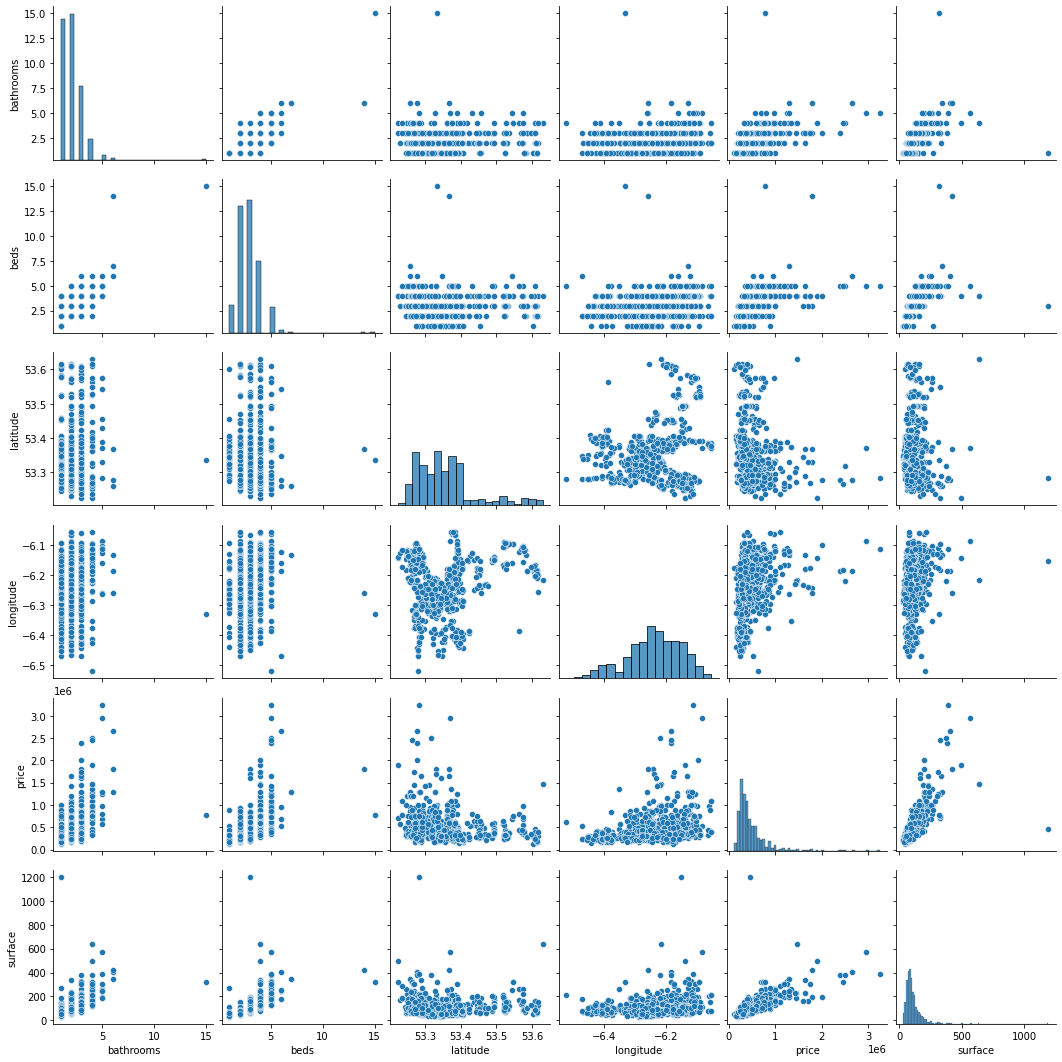

,bathrooms,beds,latitude,longitude,price,surface
count,2931.000000,2931.000000,2982.000000,2982.000000,2.892000e+03,2431.000000
mean,1.998635,2.979188,53.355991,-6.257175,5.323536e+05,318.851787
std,1.291875,1.468408,0.086748,0.141906,5.678148e+05,4389.423136
min,0.000000,0.000000,51.458439,-6.521183,1.999500e+04,3.400000
25%,1.000000,2.000000,53.298929,-6.314064,2.800000e+05,74.100000
50%,2.000000,3.000000,53.345497,-6.252254,3.800000e+05,100.000000
75%,3.000000,4.000000,53.388845,-6.196049,5.750000e+05,142.000000
max,18.000000,27.000000,53.630588,-1.744995,9.995000e+06,182108.539008


In [17]:
inspect_data(dftrain, dropcols)

#### Outliers
- bathrooms and beds both have outliers beyond 7, but there may be other features which explain these outliers, so I will keep them in the df.
- Similarly *surface* has a large outlier.

In [18]:
display(dftrain[['property_type', 'surface']].sort_values('surface').dropna())

,property_type,surface
1733,apartment,3.400000
2300,apartment,18.600000
257,studio,22.450000
172,studio,25.000000
2355,apartment,27.500000
...,...,...
178,site,16187.425690
722,site,36178.896416
88,bungalow,72236.387140
99,site,80937.128448


This outlier is a 'site'. It's status as an outlier is not grounds for dropping this sample. 

In [19]:
print("\n\ndescription_block")
print(list(df.head(3)['description_block']))
print("\n\nfacility")
print(list(df.head(3)['facility']))
print("\n\nfeatures")
print(list(df.head(3)['features']))



description_block
["A SELECTION OF 4 AND 5 BEDROOM FAMILY HOMES LOCATED BY THE SEA\n\nON VIEW BY APPOINTMENT ONLY\n\nBRAND NEW SHOW HOME\n\nStation Manor is a prestigious 'A' Rated development situated within walking distance of the historic village of Portmarnock. These generously sized, elegant 3, 4 &amp; 5 bedroom homes are ideally located just minutes from the sea front. \n\nSituated in a highly sought-after seaside village, Station Manor is an exclusive development of luxurious new homes, designed with exemplary attention to detail throughout, and offering all the relaxation and serenity of a small seaside town with the convenience of city living. \n\nFeatures\n\nPortmarnock is undoubtedly one of North Dublin's most picturesque locations, with clear views of Lambay Island and Ireland's Eye. Portmarnock is home to the famous 5 mile long stretch of white sandy beaches known as the 'Velvet Strand', which stretches all the way from Malahide to Sutton. Station Manor has this beautifu

Having looked at the '**features**, I have surmised that each feature is marked by a '\n' new line. Similarly **facilities** are listed and separated by commas - ','.
**description_block** has too much text to treat the same way

## Data Transformations

In [20]:
def col_to_colCount(df, col, divider):
  #this is designed for features and facilities to convert it to a rough count
  # of features, based on how they're typically listed in the df
  print("extracting "+col +"...")
  df[col] = df[col].fillna("")
  df[col] = df[col].apply(lambda x: x.count(divider)+1)
  return df

def sort_facilities(df, col):
  # Courtesy of Tim Hrisikos
  print("extracting facitilities...")
  df[col] = df[col].fillna("")
  df = df.join(
      df[col].str.extractall('([^,]+)')[0].groupby(level=0).apply(pd.value_counts).unstack(fill_value=0).add_prefix('facility_')
      )
  df.drop('facility', axis=1, inplace=True)
  return df

ber_classification_mapper = {
    #Thanks Nigel Portley
    "SINo666of2006exempt": 1,
    "A1": 2,
    "A2": 3,
    "A3": 4,
    "B1": 5,
    "B2": 6,
    "B3": 7,
    "C1": 8,
    "C2": 9,
    "C3": 10,
    "D1": 11,
    "D2": 12,
    "E1": 13,
    "E2": 14,
    "F": 15,
    "G": 16
}


property_category_mapper = {
  "new_development_parent": 1,
  "sale": 2,
}

def drop_cols(df, dropcols):
  print("dropping", end=" ")
  for col in dropcols:
    print(col, end=", ")
    df.drop(col, axis=1, inplace=True)
  print()
  return df

def onehotencode(df, col, drop_first=True):
  print("one hot encoding " + col)
  return pd.get_dummies(df, columns=[col], 
                        dummy_na=True, 
                        drop_first=drop_first)
  
def remove_locations_outside_Ire(df):
  # Carlos Siqueira Do Amaral noticed that there are entries from outside of Ireland.
  # This fiunction removes locations outside of Ireland's lat/ long bounds
  print("removing locations outside of Ireland")
  long0, lat0, long1, lat1 = (-9.97708574059, 51.6693012559, -6.03298539878, 55.1316222195)
  return df.loc[(df['longitude'] > long0) & (df['latitude'] > lat0)  & (df['longitude'] < long1) & (df['latitude'] < lat1)]

def frame_coordinates_to_dublin_center(df):
  print("centering coordinates around dublin city center")
  dublat, dublong = 53.350140, -6.266155
  df['dist_from_dub_center'] = (df.longitude - dublong)**2 +(df.latitude - dublat)**2
  df['latitude'] = df.latitude - dublat
  df['longitude'] = df.longitude - dublong
  return df

def treat_data(df, dropcols = []):
  # drops
  df = drop_cols(df, dropcols)
  #fillna
  df['surface'].fillna(df['surface'].median(), inplace=True)
  df['bathrooms'].fillna(df['bathrooms'].median(), inplace=True)
  df['beds'].fillna(df['beds'].median(), inplace=True)
  df['property_category'].fillna(0, inplace=True)
  #conversions
  df = col_to_colCount(df, 'features' ,'\n')
  df = sort_facilities(df, 'facility')
  df = col_to_colCount(df, 'description_block' ,'\n\n')
  df['ber_classification'] = df['ber_classification'].replace(ber_classification_mapper)
  df['ber_classification'].fillna(df['ber_classification'].mean(), inplace=True)
  df['property_category'] = df['property_category'].replace(property_category_mapper)
  df.property_type = pd.get_dummies(df.property_type, columns=['property_type'], 
                        dummy_na=True, 
                        drop_first=True)
  df.fillna(0,inplace=True)
  df = remove_locations_outside_Ire(df)
  df = frame_coordinates_to_dublin_center(df)
  try:
    df = df[(df.price > 0)]
  except:
      pass
  return df

In [21]:
df = treat_data(df, dropcols)

X_train,X_test,y_train,y_test = train_test_split(df.drop(df[['price']],axis=1), df[['price']], test_size=0.3)

print("\nX_train shape",
    X_train.shape,
    X_test.shape,
    y_train.shape,
    y_test.shape
)

dropping no_of_units, county, environment, area, ad_id, 
extracting features...
extracting facitilities...
extracting description_block...
removing locations outside of Ireland
centering coordinates around dublin city center

X_train shape (2373, 17) (1017, 17) (2373, 1) (1017, 1)


bathrooms                              0
beds                                   0
ber_classification                     0
description_block                      0
features                               0
latitude                               0
longitude                              0
price                                  0
property_category                      0
property_type                          0
surface                                0
facility_Alarm                         0
facility_Gas Fired Central Heating     0
facility_Oil Fired Central Heating     0
facility_Parking                       0
facility_Wheelchair Access             0
facility_Wired for Cable Television    0
dist_from_dub_center                   0
dtype: int64


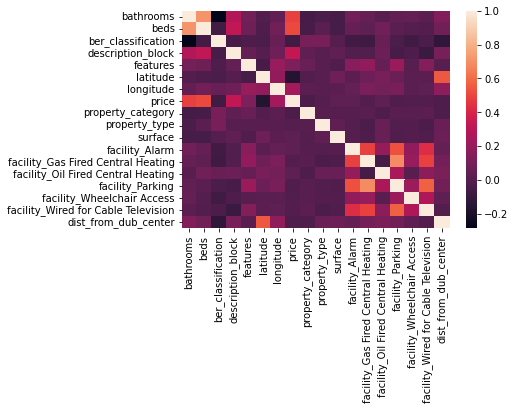

In [22]:
print(df.isna().sum())
display(sns.heatmap(df.corr()))

### final look at the data

####Train

In [23]:
display(X_train.describe())
display(y_train.head())

,bathrooms,beds,ber_classification,description_block,features,latitude,longitude,property_category,property_type,surface,facility_Alarm,facility_Gas Fired Central Heating,facility_Oil Fired Central Heating,facility_Parking,facility_Wheelchair Access,facility_Wired for Cable Television,dist_from_dub_center
count,2373.000000,2373.000000,2373.000000,2373.000000,2373.000000,2373.000000,2373.000000,2373.000000,2373.000000,2373.000000,2373.000000,2373.000000,2373.000000,2373.000000,2373.000000,2373.000000,2.373000e+03
mean,1.982722,2.959545,10.748937,11.089760,6.032027,0.006917,0.008278,1.998736,0.027391,304.179322,0.158449,0.280236,0.038769,0.385166,0.024863,0.181205,1.470925e-02
std,1.220312,1.378912,2.871727,7.659267,3.768018,0.078894,0.091514,0.035541,0.163256,4433.284284,0.382161,0.478299,0.193086,0.543999,0.155740,0.398184,1.780665e-02
min,0.000000,0.000000,1.000000,1.000000,1.000000,-0.135913,-0.255028,1.000000,0.000000,3.400000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.129816e-07
25%,1.000000,2.000000,9.000000,5.000000,1.000000,-0.050595,-0.044965,2.000000,0.000000,77.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.186974e-03
50%,2.000000,3.000000,10.691160,10.000000,7.000000,-0.004694,0.015864,2.000000,0.000000,99.900000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.455059e-03
75%,3.000000,4.000000,12.000000,16.000000,9.000000,0.037985,0.072607,2.000000,0.000000,130.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,2.081073e-02
max,18.000000,27.000000,16.000000,50.000000,11.000000,0.280448,0.211436,2.000000,1.000000,182108.539008,2.000000,2.000000,1.000000,2.000000,1.000000,2.000000,8.115278e-02


,price
2905,320000.0
2722,220000.0
1698,460000.0
1813,280000.0
883,234950.0


In [24]:
# sns.pairplot(data=df.head(10))
# plt.show()

####Test

In [25]:
display(X_test.head())
display(y_test.head())

,bathrooms,beds,ber_classification,description_block,features,latitude,longitude,property_category,property_type,surface,facility_Alarm,facility_Gas Fired Central Heating,facility_Oil Fired Central Heating,facility_Parking,facility_Wheelchair Access,facility_Wired for Cable Television,dist_from_dub_center
833,3.0,4.0,10.69116,5,1,-0.067989,-0.139354,2,0,99.9,1.0,0.0,0.0,1.0,0.0,0.0,0.024042
2464,1.0,2.0,10.69116,11,5,0.099287,0.030191,2,0,99.9,0.0,0.0,0.0,0.0,0.0,0.0,0.010769
1465,2.0,2.0,11.00000,5,8,-0.021819,-0.128379,2,0,61.9,0.0,0.0,0.0,1.0,0.0,0.0,0.016957
1768,2.0,4.0,14.00000,19,8,0.011451,0.063151,2,0,128.4,0.0,1.0,0.0,1.0,0.0,1.0,0.004119
355,3.0,3.0,10.69116,10,1,0.048275,-0.151193,2,0,99.9,1.0,1.0,0.0,1.0,0.0,1.0,0.025190


,price
833,230000.0
2464,245000.0
1465,175000.0
1768,895000.0
355,284950.0


# PIECEWISE REGRESSION

## Full Model

In [26]:
# select some features columns just for the baseline model
# assume not all of the features are informative or useful
# in this exercise you could try all of them if possible

# featrain = ['feature_1','feature_2','feature_3','cost']
# dropna: remove missing values
df_subset_train = X_train.dropna(axis=0)

# featest = ['feature_1','feature_2','feature_3']
df_subset_test = X_test.dropna(axis=0)

In [27]:
print('Number of nan in df_subset_train dataset: ',X_train.isnull().sum().sum())
print('Number of nan in df_subset_test dataset: ',X_test.isnull().sum().sum())

Number of nan in df_subset_train dataset:  0
Number of nan in df_subset_test dataset:  0


In [28]:
# train set, input columns
Xs_train = X_train.iloc[:,0:-1].values 
# train set, output column, cost
ys_train = y_train.iloc[:,-1].values.reshape(-1,1)   

# test set, input columns
Xs_test = X_test.iloc[:,0:-1].values 
# test set, output column, cost
ys_test = y_test.iloc[:,0:-1].values

In [29]:
# StandardScaler() will normalize the features i.e. each column of X, 
# so, each column/feature/variable will have μ = 0 and σ = 1
sc = StandardScaler()

Xss_train = np.hstack([Xs_train,Xs_train[:,[2]]**2])
xscaler = sc.fit(Xss_train)
Xn_train = xscaler.transform(Xss_train)

Xss_test = np.hstack([Xs_test,Xs_test[:,[2]]**2])
Xn_test = xscaler.transform(Xss_test)

ylog = np.log(ys_train.astype('float'))
yscaler = StandardScaler().fit(ylog)
yn_train = yscaler.transform(ylog)

WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.


Finished [100%]: Average Loss = 2,437.1


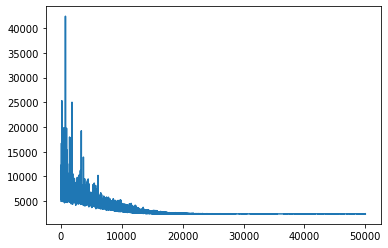

In [30]:
# model
with pm.Model() as model:
    #prior over the parameters of linear regression
    alpha = pm.Normal('alpha', mu=0, sigma=30)
    #we have one beta for each column of Xn
    beta = pm.Normal('beta', mu=0, sigma=30, shape=Xn_train.shape[1])
    #prior over the variance of the noise
    sigma = pm.HalfCauchy('sigma_n', 5)
    #linear regression model in matrix form
    mu = alpha + pm.math.dot(beta, Xn_train.T)
    #likelihood, be sure that observed is a 1d vector
    like = pm.Normal('like', mu=mu, sigma=sigma, observed=yn_train[:,0])

    

#number of iterations of the algorithms
iter = 50000 

# run the model
with model:
    approximation = pm.fit(iter,method='advi')
    
# check the convergence
plt.plot(approximation.hist);    

In [31]:
# samples from the posterior
posterior = approximation.sample(5000)

# prediction
ll=np.mean(posterior['alpha']) + np.dot(np.mean(posterior['beta'],axis=0), Xn_test.T)
y_pred_BLR = np.exp(yscaler.inverse_transform(ll.reshape(-1,1)))[:,0]
print("MAE = ",(np.mean(abs(y_pred_BLR - y_test.price.values))))
print("MAPE = ",(np.mean(abs(y_pred_BLR - y_test.price.values) / y_test.price.values)))

MAE =  360129.92375202605
MAPE =  0.3239753131649998


## Clustering

### Full Model

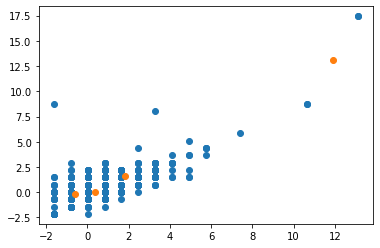

In [32]:
# training gaussian mixture model 
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=4)

# training gaussian mixture model 
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=4)
# clustering by features 1, 2
ind=[0,1]
X_ind = np.vstack([Xn_train[:,ind],Xn_test[:,ind]])
# Gaussian Mixture
gmm.fit(X_ind)
# plot blue dots
plt.scatter(X_ind[:,0],X_ind[:,1])
# centroids:  orange dots
plt.scatter(gmm.means_[:,0],gmm.means_[:,1])

### Clusters

In [33]:
# train clusters

# train clusters
clusters_train = gmm.predict(Xn_train[:,ind])
unique_train, counts_train = np.unique(clusters_train, return_counts=True)
dict(zip(unique_train, counts_train))

{0: 1141, 1: 1153, 2: 2, 3: 77}

In [34]:
# test clusters
clusters_test = gmm.predict(Xn_test[:,ind])
unique_test, counts_test = np.unique(clusters_test, return_counts=True)
dict(zip(unique_test, counts_test))

{0: 474, 1: 505, 2: 2, 3: 36}

In [35]:
# cluster 0
Xn0 = Xn_train[clusters_train==0,:]
Xtestn0 = Xn_test[clusters_test==0,:]

ylog0 = np.log(ys_train.astype('float')[clusters_train==0,:])
yscaler0 = StandardScaler().fit(ylog0)
yn0 = yscaler0.transform(ylog0)

In [36]:
# cluster 1
Xn1 = Xn_train[clusters_train==1,:]
Xtestn1 = Xn_test[clusters_test==1,:]
ylog1 = np.log(ys_train.astype('float')[clusters_train==1,:])
yscaler1 = StandardScaler().fit(ylog1)
yn1 = yscaler1.transform(ylog1)


In [37]:
# cluster 2
Xn2 = Xn_train[clusters_train==2,:]
Xtestn2 = Xn_test[clusters_test==2,:]
ylog2 = np.log(ys_train.astype('float')[clusters_train==2,:])
yscaler2 = StandardScaler().fit(ylog2)
yn2 = yscaler2.transform(ylog2)

In [38]:
# cluster 3
Xn3 = Xn_train[clusters_train==3,:]
Xtestn3 = Xn_test[clusters_test==3,:]
ylog3 = np.log(ys_train.astype('float')[clusters_train==3,:])
yscaler3 = StandardScaler().fit(ylog3)
yn3 = yscaler3.transform(ylog3)

## Piecewise Model

In [39]:
# model_0
with pm.Model() as model_0:
  # prior over the parameters of linear regression
  alpha = pm.Normal('alpha', mu=0, sigma=30)
  # we have a beta for each column of Xn0
  beta = pm.Normal('beta', mu=0, sigma=30, shape=Xn0.shape[1])
  # prior over the variance of the noise
  sigma = pm.HalfCauchy('sigma_n', 5)
  # linear regression relationship
  #linear regression model in matrix form
  mu = alpha + pm.math.dot(beta, Xn0.T)
  # likelihood, be sure that observed is a 1d vector
  like = pm.Normal('like', mu=mu, sigma=sigma, observed=yn0[:,0])

with model_0:
  # iterations of the algorithm
  approximation = pm.fit(40000,method='advi')

# samples from the posterior   
posterior0 = approximation.sample(5000)

Finished [100%]: Average Loss = 1,288


In [40]:
# model_1
with pm.Model() as model_1:
  # prior over the parameters of linear regression
  alpha = pm.Normal('alpha', mu=0, sigma=30)
  # we have a beta for each column of Xn
  beta = pm.Normal('beta', mu=0, sigma=30, shape=Xn1.shape[1])
  # prior over the variance of the noise
  sigma = pm.HalfCauchy('sigma_n', 5)
  # linear regression relationship
  #linear regression model in matrix form
  mu = alpha + pm.math.dot(beta, Xn1.T)
  # likelihood, # 
  like = pm.Normal('like', mu=mu, sigma=sigma, observed=yn1[:,0])
  
with model_1:
  # iterations of the algorithm
  approximation = pm.fit(40000,method='advi')

# samples from the posterior    
posterior1 = approximation.sample(5000)

Finished [100%]: Average Loss = 1,207


In [41]:
# model_2
with pm.Model() as model_2:
  # prior over the parameters of linear regression
  alpha = pm.Normal('alpha', mu=0, sigma=30)
  # we have a beta for each column of Xn
  beta = pm.Normal('beta', mu=0, sigma=30, shape=Xn2.shape[1])
  # prior over the variance of the noise
  sigma = pm.HalfCauchy('sigma_n', 5)
  # linear regression relationship
  # linear regression model in matrix form
  mu = alpha + pm.math.dot(beta, Xn2.T)
  # likelihood, be sure that observed is a 1d vector
  like = pm.Normal('like', mu=mu, sigma=sigma, observed=yn2[:,0])
    
with model_2:
  # iterations of the algorithms
  approximation = pm.fit(40000,method='advi')

# samples from the posterior    
posterior2 = approximation.sample(5000)

Finished [100%]: Average Loss = 31.147


In [42]:
# model_3
with pm.Model() as model3:
  # prior over the parameters of linear regression
  alpha = pm.Normal('alpha', mu=0, sigma=30)
  # we have a beta for each column of Xn
  beta = pm.Normal('beta', mu=0, sigma=30, shape=Xn3.shape[1])
  # prior over the variance of the noise
  sigma = pm.HalfCauchy('sigma_n', 5)
  # linear regression relationship
  mu = alpha + pm.math.dot(beta, Xn3.T)#linear regression model in matrix form
  # likelihood, be sure that observed is a 1d vector
  like = pm.Normal('like', mu=mu, sigma=sigma, observed=yn3[:,0])
    
with model3:
  # number of iterations of the algorithms
  approximation = pm.fit(40000,method='advi')

# samples from the posterior     
posterior3 = approximation.sample(5000)

Finished [100%]: Average Loss = 173


In [43]:
# Posterior predictive checks (PPCs)
def ppc(alpha,beta,sigma, X,  nsamples=500):
    #we select nsamples random samples from the posterior
    ind = np.random.randint(0,beta.shape[0],size=nsamples)
    alphai = alpha[ind]
    betai = beta[ind,:]
    sigmai = sigma[ind]

    Ypred = np.zeros((nsamples,X.shape[0]))
    for i in range(X.shape[0]):
        #we generate data from linear model
        y_pred = alphai + np.dot(betai, X[i:i+1,:].T).T +np.random.randn(len(sigmai))*sigmai
        Ypred[:,i]=y_pred[0,:]
    return Ypred

##Simulations

In [44]:
def plot_simulation(Ypred, ylog):
  for i in range(Ypred.shape[0]):
      az.plot_dist( Ypred[i,:],color='r',plot_kwargs={"linewidth": 0.2})
  az.plot_dist(Ypred[i,:],color='r',plot_kwargs={"linewidth": 0.2}, label="prediction")
  #plt.plot(np.linspace(-8,8,100),norm.pdf(np.linspace(-8,8,100),df=np.mean(posterior_1['nu'])))
  #plt.xlim([0,10e7])
  az.plot_dist(ylog,label='true observations');
  plt.legend()
  plt.xlabel("log(y) - output variable")
  plt.ylabel("density plot");

### Only Cluster {0..3}

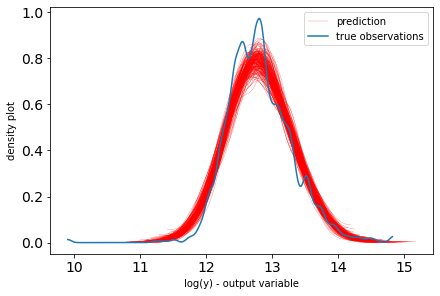

In [45]:
#Simulation
Ypred0 = yscaler0.inverse_transform(ppc(posterior0['alpha'],posterior0['beta'],posterior0['sigma_n'],Xn0,  nsamples=200))
plot_simulation(Ypred0, ylog0)

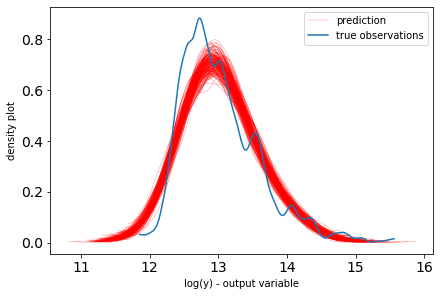

In [46]:
#Simulation
Ypred1 = yscaler1.inverse_transform(ppc(posterior1['alpha'],posterior1['beta'],posterior1['sigma_n'],Xn1,  nsamples=200))
plot_simulation(Ypred1, ylog1)

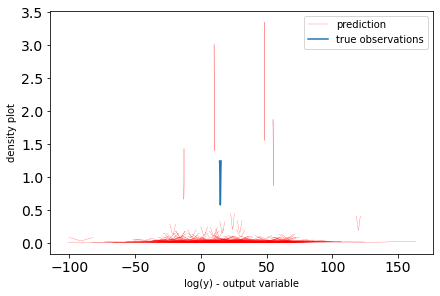

In [47]:
#Simulation
Ypred2 = yscaler2.inverse_transform(ppc(posterior2['alpha'],posterior2['beta'],posterior2['sigma_n'],Xn2,  nsamples=200))
plot_simulation(Ypred2, ylog2)

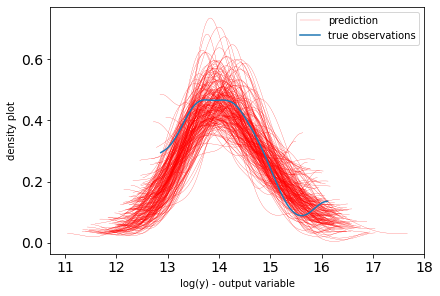

In [48]:
#Simulation
Ypred3 = yscaler3.inverse_transform(ppc(posterior3['alpha'],posterior3['beta'],posterior3['sigma_n'],Xn3,  nsamples=200))
plot_simulation(Ypred3, ylog3)

## Overall

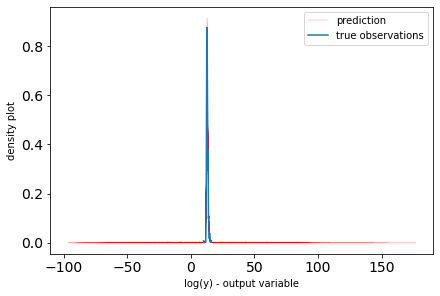

In [49]:
# posteriors
Ypred0 = ppc(posterior0['alpha'],posterior0['beta'],posterior0['sigma_n'],Xn0,  nsamples=200)
Ypred1 = ppc(posterior1['alpha'],posterior1['beta'],posterior1['sigma_n'],Xn1,  nsamples=200)
Ypred2 = ppc(posterior2['alpha'],posterior2['beta'],posterior2['sigma_n'],Xn2,  nsamples=200)
Ypred3 = ppc(posterior3['alpha'],posterior3['beta'],posterior3['sigma_n'],Xn3,  nsamples=200)

# simulation
Ypred = np.hstack([ yscaler0.inverse_transform(Ypred0),
                 yscaler1.inverse_transform(Ypred1),
                 yscaler2.inverse_transform(Ypred2),
                 yscaler3.inverse_transform(Ypred3)])

# prediction
for i in range(Ypred.shape[0]):
    az.plot_dist( Ypred[i,:],color='r',plot_kwargs={"linewidth": 0.2})

# plot
az.plot_dist(Ypred[i,:],color='r',plot_kwargs={"linewidth": 0.2}, label="prediction")
ylog=np.vstack([ylog0,ylog1,ylog2,ylog3])
az.plot_dist(ylog,label='true observations');
plt.legend()
plt.xlabel("log(y) - output variable")
plt.ylabel("density plot");

## Test set performance

In [50]:
# cluster 0
y_pred_BLR0 = np.exp(yscaler0.inverse_transform(np.mean(posterior0['alpha']) 
              + np.dot(np.mean(posterior0['beta'],axis=0), Xtestn0.T)))
print("Size Cluster0", np.sum(clusters_test==0), ", MAE Cluster0=",
      (np.mean(abs(y_pred_BLR0 - y_test.price.values[clusters_test==0]))))

# cluster 1
y_pred_BLR1 = np.exp(yscaler1.inverse_transform(np.mean(posterior1['alpha']) 
              + np.dot(np.mean(posterior1['beta'],axis=0), Xtestn1.T)))
print("Size Cluster1", np.sum(clusters_test==1), ", MAE Cluster1=",
      (np.mean(abs(y_pred_BLR1 - y_test.price.values[clusters_test==1]))))

# cluster 2
y_pred_BLR2 = np.exp(yscaler2.inverse_transform(np.mean(posterior2['alpha']) 
              + np.dot(np.mean(posterior2['beta'],axis=0), Xtestn2.T)))
print("Size Cluster2", np.sum(clusters_test==2), ", MAE Cluster2=",
      (np.mean(abs(y_pred_BLR2 - y_test.price.values[clusters_test==2]))))

# cluster 3
y_pred_BLR3 = np.exp(yscaler3.inverse_transform(np.mean(posterior3['alpha']) 
              + np.dot(np.mean(posterior3['beta'],axis=0), Xtestn3.T)))
print("Size Cluster3", np.sum(clusters_test==3), ", MAE Cluster3=",
      (np.mean(abs(y_pred_BLR3 - y_test.price.values[clusters_test==3]))))

# joint
joint=np.hstack([abs(y_pred_BLR0 - y_test.price.values[clusters_test==0]),
                 abs(y_pred_BLR1 - y_test.price.values[clusters_test==1]),
                 abs(y_pred_BLR2 - y_test.price.values[clusters_test==2]),
                 abs(y_pred_BLR3 - y_test.price.values[clusters_test==3])])

# MAE
print("MAE=",np.mean(joint))

Size Cluster0 474 , MAE Cluster0= 111638.04549896289
Size Cluster1 505 , MAE Cluster1= 201225.20870964686
Size Cluster2 2 , MAE Cluster2= 3523195.2973623937
Size Cluster3 36 , MAE Cluster3= 857962.8229172559
MAE= 189250.9500340473


### PPC on the Test set



(10.0, 16.0)

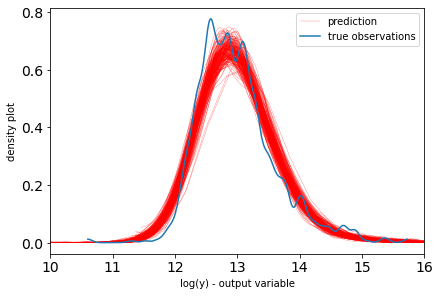

In [51]:
## Posterior predictive checks (PPCs)

num_samples2 = 200
Ypred0 = ppc(posterior0['alpha'],posterior0['beta'],posterior0['sigma_n'],Xtestn0, nsamples=num_samples2)
Ypred1 = ppc(posterior1['alpha'],posterior1['beta'],posterior1['sigma_n'],Xtestn1, nsamples=num_samples2)
Ypred2 = ppc(posterior2['alpha'],posterior2['beta'],posterior2['sigma_n'],Xtestn2, nsamples=num_samples2)
Ypred3 = ppc(posterior3['alpha'],posterior3['beta'],posterior3['sigma_n'],Xtestn3, nsamples=num_samples2)

# Stack arrays in sequence horizontally (column wise)
Ypred = np.hstack([yscaler0.inverse_transform(Ypred0),
                 yscaler1.inverse_transform(Ypred1),
                 yscaler2.inverse_transform(Ypred2),
                 yscaler3.inverse_transform(Ypred3)])

# plot prediction shape
for i in range(Ypred.shape[0]):
    az.plot_dist( Ypred[i,:],color='r',plot_kwargs={"linewidth": 0.2})
# label
az.plot_dist(Ypred[i,:],color='r',plot_kwargs={"linewidth": 0.2}, label="prediction")

# true observations
az.plot_dist(np.log(y_test),label='true observations');
plt.legend()
plt.xlabel("log(y) - output variable")
plt.ylabel("density plot");
plt.xlim(10, 16)

# SUMMARY